## Exploratory Data Analysis

### Previewing Data, Checking Unique Fields, & Calculating General Statistics

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
PREPROCESSED_DATA_PATH = "../../data/preprocessed/"
PREPROCESSED_DATA_FILES = os.listdir(PREPROCESSED_DATA_PATH)

In [3]:
ALL_RACE_DATA_DF = pd.DataFrame()
for file in PREPROCESSED_DATA_FILES:
    if file == "drivers.csv" or file == "all_seasons_results.csv" or file == "feature_averages_for_all_seasons.csv":
        continue
    file_path = os.path.join(PREPROCESSED_DATA_PATH, file)
    current_year_df = pd.read_csv(file_path)
    ALL_RACE_DATA_DF = pd.concat([ALL_RACE_DATA_DF, current_year_df])

In [4]:
DRIVERS_DF = pd.read_csv(os.path.join(PREPROCESSED_DATA_PATH, "drivers.csv"))

#### Unique Constructor Teams (2018 - 2024)

First, I want to see how many teams are in my dataset to check naming convention and see how rebrandings were handled (e.g. "Force India" to "Racing Point" to "Aston Martin").

In [5]:
TEAMS_DF = ALL_RACE_DATA_DF[["TeamId", "TeamName"]].drop_duplicates().sort_values(by="TeamId").reset_index(drop=True)
TEAMS_DF

,TeamId,TeamName
0,alfa,Alfa Romeo
1,alfa,Alfa Romeo Racing
2,alphatauri,AlphaTauri
3,alpine,Alpine
4,aston_martin,Aston Martin
5,ferrari,Ferrari
6,force_india,Force India
7,force_india,Racing Point
8,haas,Haas F1 Team
9,mclaren,McLaren


Based on this DataFrame, there seems to be some mismatch due to re-brandings and some naming inconsistencies.

<li>The sauber TeamId has 2 TeamName values: Sauber and Kick Sauber</li>
<li>The alfa TeamId has 2 TeamName values: Alfa Romeo and Alfa Romeo Racing</li>
<li>The Alfa Romeo and Kick Sauber teams are the same due to re-branding</li>
<li>The rebranding for the current RB team has multiple TeamId and TeamName values (toro_rosso - Toro Rosso, alphatauri - AlphaTauri, rb - RB)</li>
<li>The rebranding for the current Alpine team has multiple TeamId and TeamName values (renault - Renault, alpine - Alpine)</li>
<li>The rebranding for the current Aston Martin team has multiple TeamId and TeamName values (force_india - Force India, force_india - Racing Point, racing_point - Racing Point, aston_martin - Aston Martin)</li>

In [6]:
def fix_team_data(df:pd.DataFrame):
    # Fix the Sauber and Alfa Romeo teams
    df["TeamId"] = df["TeamId"].replace("alfa", "sauber")
    df["TeamName"] = df["TeamName"].replace("Alfa Romeo Racing", "Kick Sauber")
    df["TeamName"] = df["TeamName"].replace("Alfa Romeo", "Kick Sauber")
    df["TeamName"] = df["TeamName"].replace("Sauber", "Kick Sauber")

    # Rename the old RB TeamIds and TeamNames with the current values
    df["TeamId"] = df["TeamId"].replace(["toro_rosso", "alphatauri"], ["rb", "rb"])
    df["TeamName"] = df["TeamName"].replace(["Toro Rosso", "AlphaTauri"], ["RB", "RB"])

    # Replace the Renault TeamId and TeamName with the current Alpine team's
    df["TeamId"] = df["TeamId"].replace("renault", "alpine")
    df["TeamName"] = df["TeamName"].replace("Renault", "Alpine")

    # Rename the old Aston Martin TeamIds and TeamNames with the current values
    df["TeamId"] = df["TeamId"].replace(["force_india", "racing_point"], ["aston_martin", "aston_martin"])
    df["TeamName"] = df["TeamName"].replace(["Force India", "Racing Point"], ["Aston Martin", "Aston Martin"])

    return df.drop_duplicates().sort_values(by="TeamId").reset_index(drop=True)

TEAMS_DF = fix_team_data(TEAMS_DF)
TEAMS_DF

,TeamId,TeamName
0,alpine,Alpine
1,aston_martin,Aston Martin
2,ferrari,Ferrari
3,haas,Haas F1 Team
4,mclaren,McLaren
5,mercedes,Mercedes
6,rb,RB
7,red_bull,Red Bull Racing
8,sauber,Kick Sauber
9,williams,Williams


This final DataFrame shows the 10 teams which is aligned with my knowedge and are currently on the grid as of the creation of this project in August and September 2025.

The corrections made in the cell above will be part of the data processing phase.

In [7]:
ALL_RACE_DATA_DF = fix_team_data(ALL_RACE_DATA_DF)
ALL_RACE_DATA_DF = ALL_RACE_DATA_DF.sort_values(by=["Year", "Round", "Position"]).reset_index(drop=True)

### Exploring Statistics Likely to Predict Constructor Championship Results (2018 - 2024)

#### 1. Total Points Earned by Each Team Per Season

To begin with the data, let's start with the most important stats: total points by each constructor team for each season.

In [8]:
POINTS_PER_SEASON_BY_TEAM_DF = ALL_RACE_DATA_DF[["Year", "TeamId", "Points"]].groupby(["Year", "TeamId"])["Points"].sum().reset_index()
POINTS_PER_SEASON_BY_TEAM_DF = POINTS_PER_SEASON_BY_TEAM_DF.sort_values(by=["Year", "Points"], ascending=[True, False]).reset_index(drop=True)

POINTS_PER_SEASON_BY_TEAM_DF.head(10)

,Year,TeamId,Points
0,2018,mercedes,655.0
1,2018,ferrari,571.0
2,2018,red_bull,419.0
3,2018,alpine,122.0
4,2018,aston_martin,111.0
5,2018,haas,93.0
6,2018,mclaren,62.0
7,2018,sauber,48.0
8,2018,rb,33.0
9,2018,williams,7.0


In [9]:
POINTS_PER_SEASON_BY_TEAM_DF.tail(10)

,Year,TeamId,Points
60,2024,mclaren,666.0
61,2024,ferrari,652.0
62,2024,red_bull,589.0
63,2024,mercedes,468.0
64,2024,aston_martin,94.0
65,2024,alpine,65.0
66,2024,haas,58.0
67,2024,rb,46.0
68,2024,williams,17.0
69,2024,sauber,4.0


#### 2. Average Points Earned by Each Team from 2018 through 2024

Next, let's calculate the average points earned by a team from 2018 through 2024.

In [10]:
AVG_TOTAL_POINTS_PER_SEASON_BY_TEAM_DF = POINTS_PER_SEASON_BY_TEAM_DF.groupby(["TeamId"])["Points"].mean().reset_index()
AVG_TOTAL_POINTS_PER_SEASON_BY_TEAM_DF = AVG_TOTAL_POINTS_PER_SEASON_BY_TEAM_DF.sort_values(by="Points", ascending=False).reset_index(drop=True)
AVG_TOTAL_POINTS_PER_SEASON_BY_TEAM_DF

,TeamId,Points
0,mercedes,567.500000
1,red_bull,564.071429
2,ferrari,448.785714
3,mclaren,258.714286
4,alpine,129.571429
5,aston_martin,128.571429
6,rb,67.571429
7,haas,33.000000
8,sauber,28.714286
9,williams,12.000000


As expected, Mercedes and Red Bull top the list from 2018 through 2024 for average points earned in a season. While this is expected and there are top teams in F1, I hope that this won't skew the model to be biased for these two teams. This is something to consider when finetuning the model.

Aside from this note, here is a bar chart visualization of the average points earned by each team in a season. The dominance of Mercedes and Red Bull is very prominent in this dashboard.

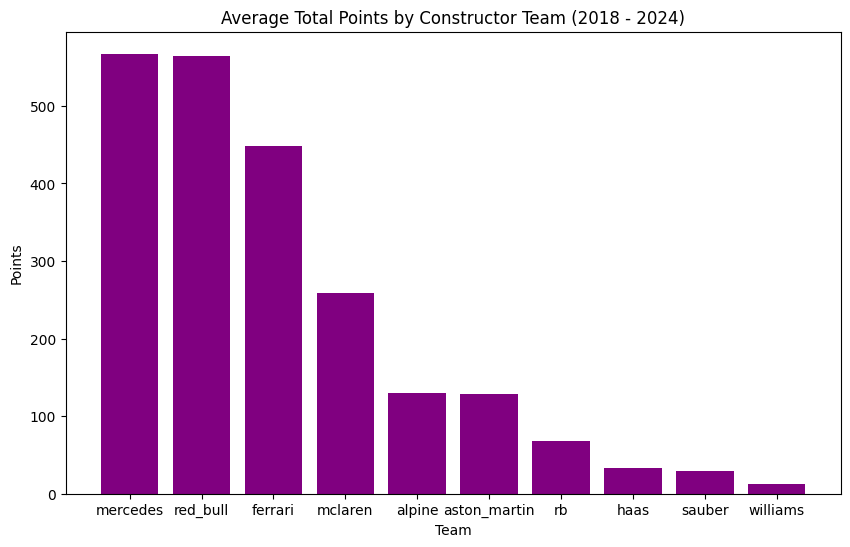

In [11]:
plt.figure(figsize=(10, 6))
plt.bar(AVG_TOTAL_POINTS_PER_SEASON_BY_TEAM_DF["TeamId"], AVG_TOTAL_POINTS_PER_SEASON_BY_TEAM_DF["Points"], color="purple")
plt.xlabel("Team")
plt.ylabel("Points")
plt.title("Average Total Points by Constructor Team (2018 - 2024)")
plt.show()

#### 3. Average Race Position by Each Team

Obviously, the total number of points a team earns throughout a season is largely determined by race and sprint results since these are where the points are earned.

Let's find the average resulting position of each team for each season.

In [12]:
RACE_POSITION_BY_TEAM_BY_YEAR_DF = ALL_RACE_DATA_DF[["Year", "TeamId", "Position"]].groupby(["Year", "TeamId"])["Position"].mean().reset_index()
RACE_POSITION_BY_TEAM_BY_YEAR_DF = RACE_POSITION_BY_TEAM_BY_YEAR_DF.sort_values(by=["Year", "Position"], ascending=[True, True]).reset_index(drop=True)

RACE_POSITION_BY_TEAM_BY_YEAR_DF.head(10)

,Year,TeamId,Position
0,2018,mercedes,3.857143
1,2018,ferrari,4.928571
2,2018,red_bull,7.642857
3,2018,alpine,11.071429
4,2018,aston_martin,11.190476
5,2018,haas,11.976190
6,2018,mclaren,12.761905
7,2018,sauber,12.785714
8,2018,rb,13.880952
9,2018,williams,14.904762


In [13]:
RACE_POSITION_BY_TEAM_BY_YEAR_DF.tail(10)

,Year,TeamId,Position
60,2024,mclaren,4.816667
61,2024,ferrari,4.966667
62,2024,red_bull,6.416667
63,2024,mercedes,6.900000
64,2024,haas,12.383333
65,2024,aston_martin,12.533333
66,2024,alpine,13.100000
67,2024,rb,13.133333
68,2024,williams,15.016949
69,2024,sauber,15.650000


Here, in the average race position DataFrame, we see some more variability in the data. Therefore, this feature is probably very indicative of whether a team will win the Constructor's Championship.

Let's calculate the average race position across the 2018 through 2024 seasons for each team.

In [14]:
AVG_POSITION_BY_TEAM_DF = RACE_POSITION_BY_TEAM_BY_YEAR_DF.groupby(["TeamId"])["Position"].mean().reset_index()
AVG_POSITION_BY_TEAM_DF = AVG_POSITION_BY_TEAM_DF.sort_values(by="Position", ascending=True).reset_index(drop=True)
AVG_POSITION_BY_TEAM_DF

,TeamId,Position
0,mercedes,5.062729
1,red_bull,6.006963
2,ferrari,6.761078
3,mclaren,9.113303
4,alpine,11.004930
5,aston_martin,11.134409
6,rb,12.594412
7,sauber,13.700250
8,haas,14.357833
9,williams,15.183889


Here is a box plot visualization of the average race position for each team from 2018 through 2024.

I chose this type of visualization over a bar chart since I wanted to show the variation of race positions within teams. The averages plotted alone can be misleading, as the teams' performances can vary from year to year.

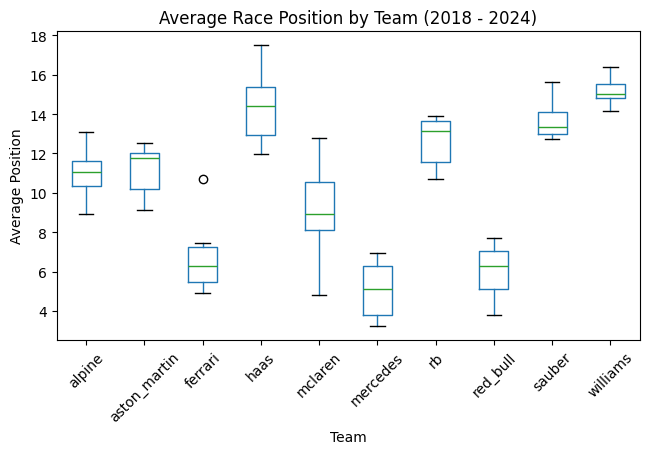

In [15]:
RACE_POSITION_BY_TEAM_BY_YEAR_DF.boxplot(column="Position", by="TeamId", grid=False)
plt.suptitle("")
plt.title("Average Race Position by Team (2018 - 2024)")
plt.xlabel("Team")
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel("Average Position")
plt.show()

#### 4. Average Grid Position by Each Team

Another statistic that can help predict whether a team will win the Constructor's Championship is the qualifying or grid position of their drivers. However, a lot can happen during the race which might allow drivers to lose or gain position, so it's probably not as signifcant as the race position.

Regardless, let's calculate the same statistics for grid position.

In [16]:
GRID_POSITION_BY_TEAM_BY_YEAR_DF = ALL_RACE_DATA_DF[["Year", "TeamId", "GridPosition"]].groupby(["Year", "TeamId"])["GridPosition"].mean().reset_index()
GRID_POSITION_BY_TEAM_BY_YEAR_DF = GRID_POSITION_BY_TEAM_BY_YEAR_DF.sort_values(by=["Year", "GridPosition"], ascending=[True, True]).reset_index(drop=True)

GRID_POSITION_BY_TEAM_BY_YEAR_DF.head(10)

,Year,TeamId,GridPosition
0,2018,ferrari,3.309524
1,2018,mercedes,3.428571
2,2018,red_bull,7.619048
3,2018,haas,10.214286
4,2018,alpine,10.642857
5,2018,aston_martin,10.690476
6,2018,sauber,13.833333
7,2018,rb,14.047619
8,2018,mclaren,14.404762
9,2018,williams,16.333333


In [17]:
GRID_POSITION_BY_TEAM_BY_YEAR_DF.tail(10)

,Year,TeamId,GridPosition
60,2024,mclaren,4.450000
61,2024,ferrari,5.516667
62,2024,red_bull,6.433333
63,2024,mercedes,7.133333
64,2024,aston_martin,11.283333
65,2024,rb,12.300000
66,2024,haas,12.816667
67,2024,alpine,13.283333
68,2024,williams,15.067797
69,2024,sauber,16.300000


In [18]:
AVG_GRID_POSITION_BY_TEAM_DF = GRID_POSITION_BY_TEAM_BY_YEAR_DF.groupby(["TeamId"])["GridPosition"].mean().reset_index()
AVG_GRID_POSITION_BY_TEAM_DF = AVG_GRID_POSITION_BY_TEAM_DF.sort_values(by="GridPosition", ascending=True).reset_index(drop=True)
AVG_GRID_POSITION_BY_TEAM_DF

,TeamId,GridPosition
0,mercedes,4.712911
1,red_bull,5.518970
2,ferrari,5.744890
3,mclaren,9.020240
4,alpine,10.695912
5,aston_martin,11.385041
6,rb,12.184838
7,haas,13.369353
8,sauber,14.176363
9,williams,15.557507


Similarly, here is a box plot visualization of the average grid position for each team from 2018 through 2024.

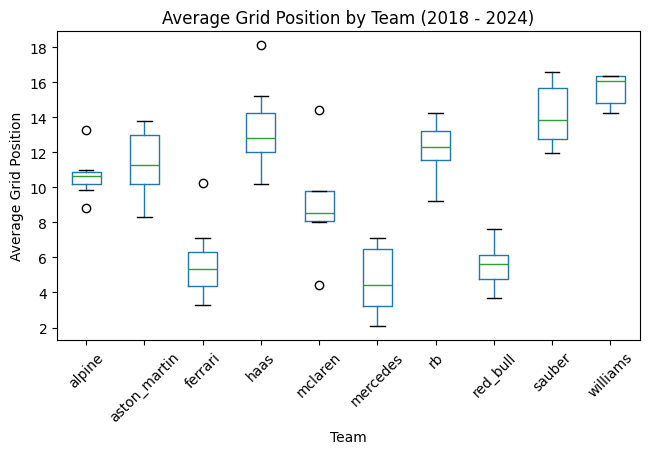

In [19]:
GRID_POSITION_BY_TEAM_BY_YEAR_DF.boxplot(column="GridPosition", by="TeamId", grid=False)
plt.suptitle("")
plt.title("Average Grid Position by Team (2018 - 2024)")
plt.xlabel("Team")
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel("Average Grid Position")
plt.show()

#### 5. Rate of DNFs for Each Team

Of course, a World Constructor Champion team cannot be a champion if the cars had to be retired often or if the drivers did not finish (DNF) the race. Therefore, the keeping low retirement and DNF rates are probably another strong indicator of whether a team will be a champion.

Before we can calculate the retirement and DNF rates, we need to investigate how fastf1 labels a retirement from a crash versus a car issue. There is some documentation on the various values for <code>SessionResults</code> <a href="https://docs.fastf1.dev/core.html#fastf1.core.SessionResults">here</a>.

In [20]:
RACE_STATUS_VALUES = ALL_RACE_DATA_DF["Status"].unique().tolist()
RACE_STATUS_VALUES

['Finished',
 '+1 Lap',
 'Wheel',
 'Engine',
 'Steering',
 'Brakes',
 'Puncture',
 'Electrical',
 'Collision damage',
 'Accident',
 'Collision',
 '+2 Laps',
 '+3 Laps',
 'Gearbox',
 'Oil leak',
 'Turbo',
 'Exhaust',
 'Fuel pressure',
 'Hydraulics',
 'Tyre',
 'Power Unit',
 'Retired',
 'Power loss',
 'Suspension',
 'Disqualified',
 'Mechanical',
 'Battery',
 'Overheating',
 'Damage',
 'Out of fuel',
 'Transmission',
 'Spun off',
 'Water pressure',
 'Withdrew',
 'Electronics',
 '+5 Laps',
 'Debris',
 'Radiator',
 'Illness',
 'Wheel nut',
 'Driveshaft',
 'Vibrations',
 'Rear wing',
 'Cooling system',
 'Water pump',
 'Fuel leak',
 'Front wing',
 'Water leak',
 'Fuel pump',
 'Undertray',
 '+6 Laps',
 'Differential',
 'Lapped',
 'Did not start']

As you can see from all the unique Status values, there are some naming inconsistencies and some of these labels don't necessarily mean that the driver did not finish or had to retire.

Another column in the data, ClassifiedPosition, may be more helpful than Status.

In [21]:
CLASSIFIED_POSITION_VALUES = ALL_RACE_DATA_DF["ClassifiedPosition"].unique().tolist()
CLASSIFIED_POSITION_VALUES

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 'R',
 '16',
 '17',
 '18',
 '19',
 '20',
 'D',
 'W']

According to the fastf1 documentation, the integer values represent a driver finished the race at a specific position and the letters represent some type of special status.

<li>"R" - Retired</li>
<li>"D" - Disqualified</li>
<li>"W" - Withdrawn</li>

There are other letters, "E" - Excluded, "F" - Failed to Qualify, and "N" - Not Qualified, but these were not found in our dataset.

For simplicity, I'm going to construct a new column called "DNF" where values will be either 0 for a Finish or 1 for a DNF.

Additionally, I will consider any of the non-numeric values a DNF. Even though a disqualification may mean a driver finished the race, it doesn't mean they earn points for the team, so it makes more sense to consider this a DNF.

In [22]:
ALL_RACE_DATA_DF["isDNF"] = ALL_RACE_DATA_DF["ClassifiedPosition"].apply(lambda x: 1 if not x.isnumeric() else 0)

# Preview the new column
ALL_RACE_DATA_DF[["Year", "Round", "TeamId", "Position", "isDNF"]].head(10)

,Year,Round,TeamId,Position,isDNF
0,2018,1,ferrari,1.0,0
1,2018,1,mercedes,2.0,0
2,2018,1,ferrari,3.0,0
3,2018,1,red_bull,4.0,0
4,2018,1,mclaren,5.0,0
5,2018,1,red_bull,6.0,0
6,2018,1,alpine,7.0,0
7,2018,1,mercedes,8.0,0
8,2018,1,mclaren,9.0,0
9,2018,1,alpine,10.0,0


Now that this "DNF" column is part of our DataFrame, we can begin calculating DNF rates.

In [23]:
DNF_RATE_BY_TEAM_BY_YEAR_DF = ALL_RACE_DATA_DF[["Year", "TeamId", "isDNF"]].groupby(["Year", "TeamId"])["isDNF"].mean().reset_index()
DNF_RATE_BY_TEAM_BY_YEAR_DF = DNF_RATE_BY_TEAM_BY_YEAR_DF.sort_values(by=["Year", "isDNF"], ascending=[True, True]).reset_index(drop=True)

DNF_RATE_BY_TEAM_BY_YEAR_DF.head(10)

,Year,TeamId,isDNF
0,2018,mercedes,0.071429
1,2018,ferrari,0.119048
2,2018,williams,0.119048
3,2018,aston_martin,0.190476
4,2018,mclaren,0.190476
5,2018,alpine,0.214286
6,2018,haas,0.214286
7,2018,sauber,0.238095
8,2018,rb,0.261905
9,2018,red_bull,0.285714


In [24]:
DNF_RATE_BY_TEAM_BY_YEAR_DF.tail(10)

,Year,TeamId,isDNF
60,2024,mclaren,0.016667
61,2024,ferrari,0.050000
62,2024,mercedes,0.050000
63,2024,sauber,0.066667
64,2024,aston_martin,0.083333
65,2024,haas,0.083333
66,2024,red_bull,0.083333
67,2024,alpine,0.100000
68,2024,rb,0.100000
69,2024,williams,0.203390


Let's also look at the overall rate of DNFs for each team across all 7 years of data we have.

In [25]:
AVG_DNF_RATE_BY_TEAM_DF = DNF_RATE_BY_TEAM_BY_YEAR_DF.groupby(["TeamId"])["isDNF"].mean().reset_index()
AVG_DNF_RATE_BY_TEAM_DF = AVG_DNF_RATE_BY_TEAM_DF.sort_values(by="isDNF", ascending=True).reset_index(drop=True)
AVG_DNF_RATE_BY_TEAM_DF

,TeamId,isDNF
0,mercedes,0.058555
1,mclaren,0.103814
2,ferrari,0.109700
3,red_bull,0.124054
4,sauber,0.125854
5,aston_martin,0.131112
6,rb,0.143439
7,alpine,0.157471
8,williams,0.163161
9,haas,0.166012


Again, since the rate of DNFs can vary drastically from year to year, I'm going to represent this statistic using another box plot.

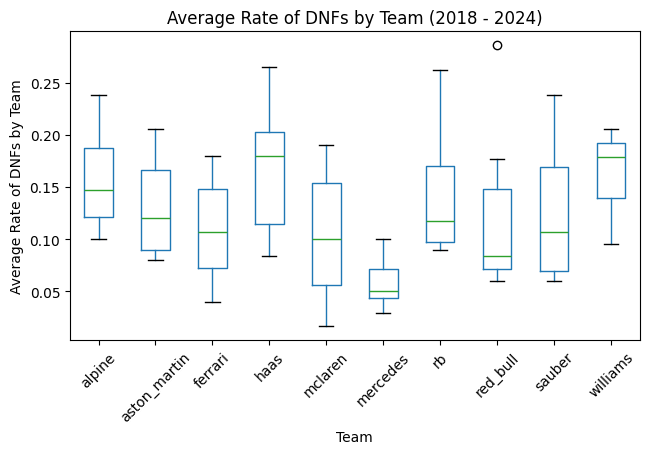

In [26]:
DNF_RATE_BY_TEAM_BY_YEAR_DF.boxplot(column="isDNF", by="TeamId", grid=False)
plt.suptitle("")
plt.title("Average Rate of DNFs by Team (2018 - 2024)")
plt.xlabel("Team")
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel("Average Rate of DNFs by Team")
plt.show()

#### 6. Average Number of Podium & Points Finishes

The way the points system works is that only the top 10 finishers receive points. 1st place receives the most at 25 points and that value decreases until 10th place, which only receives 1 point. That being said, teams with a podium finish (1st, 2nd, or 3rd place) earn a ton of points compared to 4th through 10th and positions out of the points.

Let's find out the number of podium finishes and average number of podium finishes for each team from 2018 through 2024.

In [27]:
ALL_RACE_DATA_DF["isPodiumFinish"] = ALL_RACE_DATA_DF["Points"].apply(lambda x: 1 if x >= 15 else 0)
ALL_RACE_DATA_DF["isPointsFinish"] = ALL_RACE_DATA_DF["Points"].apply(lambda x: 1 if x > 0 else 0)

ALL_RACE_DATA_DF[["Year", "Round", "TeamId", "DriverId", "Points", "isPodiumFinish", "isPointsFinish"]].head(10)

,Year,Round,TeamId,DriverId,Points,isPodiumFinish,isPointsFinish
0,2018,1,ferrari,vettel,25.0,1,1
1,2018,1,mercedes,hamilton,18.0,1,1
2,2018,1,ferrari,raikkonen,15.0,1,1
3,2018,1,red_bull,ricciardo,12.0,0,1
4,2018,1,mclaren,alonso,10.0,0,1
5,2018,1,red_bull,max_verstappen,8.0,0,1
6,2018,1,alpine,hulkenberg,6.0,0,1
7,2018,1,mercedes,bottas,4.0,0,1
8,2018,1,mclaren,vandoorne,2.0,0,1
9,2018,1,alpine,sainz,1.0,0,1


In [28]:
PODIUMS_BY_TEAM_BY_YEAR_DF = ALL_RACE_DATA_DF[["Year", "TeamId", "isPodiumFinish"]].groupby(["Year", "TeamId"])["isPodiumFinish"].mean().reset_index()
PODIUMS_BY_TEAM_BY_YEAR_DF = PODIUMS_BY_TEAM_BY_YEAR_DF.sort_values(by=["Year", "isPodiumFinish"], ascending=[True, False]).reset_index(drop=True)

PODIUMS_BY_TEAM_BY_YEAR_DF.head(10)

,Year,TeamId,isPodiumFinish
0,2018,mercedes,0.595238
1,2018,ferrari,0.571429
2,2018,red_bull,0.309524
3,2018,aston_martin,0.023810
4,2018,alpine,0.000000
5,2018,haas,0.000000
6,2018,mclaren,0.000000
7,2018,rb,0.000000
8,2018,sauber,0.000000
9,2018,williams,0.000000


In [29]:
POINTS_BY_TEAM_BY_YEAR_DF = ALL_RACE_DATA_DF[["Year", "TeamId", "isPointsFinish"]].groupby(["Year", "TeamId"])["isPointsFinish"].mean().reset_index()
POINTS_BY_TEAM_BY_YEAR_DF = POINTS_BY_TEAM_BY_YEAR_DF.sort_values(by=["Year", "isPointsFinish"], ascending=[True, False]).reset_index(drop=True)

POINTS_BY_TEAM_BY_YEAR_DF.head(10)

,Year,TeamId,isPointsFinish
0,2018,mercedes,0.928571
1,2018,ferrari,0.880952
2,2018,red_bull,0.714286
3,2018,alpine,0.571429
4,2018,aston_martin,0.523810
5,2018,haas,0.428571
6,2018,sauber,0.380952
7,2018,mclaren,0.309524
8,2018,rb,0.190476
9,2018,williams,0.071429


### Finalizing the Data

After looking through those potentially relevant statistics, let me compile them all into one DataFrame.

Let's begin with the points per team per year.

In [30]:
F1_DATA_DF = pd.DataFrame()
F1_DATA_DF = pd.concat([F1_DATA_DF, POINTS_PER_SEASON_BY_TEAM_DF], ignore_index=True)
F1_DATA_DF["FinalRanking"] = list(range(1, 11)) * 7

F1_DATA_DF.head(10)

,Year,TeamId,Points,FinalRanking
0,2018,mercedes,655.0,1
1,2018,ferrari,571.0,2
2,2018,red_bull,419.0,3
3,2018,alpine,122.0,4
4,2018,aston_martin,111.0,5
5,2018,haas,93.0,6
6,2018,mclaren,62.0,7
7,2018,sauber,48.0,8
8,2018,rb,33.0,9
9,2018,williams,7.0,10


In [31]:
F1_DATA_DF = pd.merge(F1_DATA_DF, RACE_POSITION_BY_TEAM_BY_YEAR_DF, on=["Year", "TeamId"], how="inner")
F1_DATA_DF.head(10)

,Year,TeamId,Points,FinalRanking,Position
0,2018,mercedes,655.0,1,3.857143
1,2018,ferrari,571.0,2,4.928571
2,2018,red_bull,419.0,3,7.642857
3,2018,alpine,122.0,4,11.071429
4,2018,aston_martin,111.0,5,11.190476
5,2018,haas,93.0,6,11.976190
6,2018,mclaren,62.0,7,12.761905
7,2018,sauber,48.0,8,12.785714
8,2018,rb,33.0,9,13.880952
9,2018,williams,7.0,10,14.904762


In [32]:
F1_DATA_DF = pd.merge(F1_DATA_DF, GRID_POSITION_BY_TEAM_BY_YEAR_DF, on=["Year", "TeamId"], how="inner")
F1_DATA_DF.head(10)

,Year,TeamId,Points,FinalRanking,Position,GridPosition
0,2018,mercedes,655.0,1,3.857143,3.428571
1,2018,ferrari,571.0,2,4.928571,3.309524
2,2018,red_bull,419.0,3,7.642857,7.619048
3,2018,alpine,122.0,4,11.071429,10.642857
4,2018,aston_martin,111.0,5,11.190476,10.690476
5,2018,haas,93.0,6,11.976190,10.214286
6,2018,mclaren,62.0,7,12.761905,14.404762
7,2018,sauber,48.0,8,12.785714,13.833333
8,2018,rb,33.0,9,13.880952,14.047619
9,2018,williams,7.0,10,14.904762,16.333333


In [33]:
F1_DATA_DF = pd.merge(F1_DATA_DF, DNF_RATE_BY_TEAM_BY_YEAR_DF, on=["Year", "TeamId"], how="inner")
F1_DATA_DF.head(10)

,Year,TeamId,Points,FinalRanking,Position,GridPosition,isDNF
0,2018,mercedes,655.0,1,3.857143,3.428571,0.071429
1,2018,ferrari,571.0,2,4.928571,3.309524,0.119048
2,2018,red_bull,419.0,3,7.642857,7.619048,0.285714
3,2018,alpine,122.0,4,11.071429,10.642857,0.214286
4,2018,aston_martin,111.0,5,11.190476,10.690476,0.190476
5,2018,haas,93.0,6,11.976190,10.214286,0.214286
6,2018,mclaren,62.0,7,12.761905,14.404762,0.190476
7,2018,sauber,48.0,8,12.785714,13.833333,0.238095
8,2018,rb,33.0,9,13.880952,14.047619,0.261905
9,2018,williams,7.0,10,14.904762,16.333333,0.119048


In [34]:
F1_DATA_DF = pd.merge(F1_DATA_DF, PODIUMS_BY_TEAM_BY_YEAR_DF, on=["Year", "TeamId"], how="inner")
F1_DATA_DF.head(10)

,Year,TeamId,Points,FinalRanking,Position,GridPosition,isDNF,isPodiumFinish
0,2018,mercedes,655.0,1,3.857143,3.428571,0.071429,0.595238
1,2018,ferrari,571.0,2,4.928571,3.309524,0.119048,0.571429
2,2018,red_bull,419.0,3,7.642857,7.619048,0.285714,0.309524
3,2018,alpine,122.0,4,11.071429,10.642857,0.214286,0.000000
4,2018,aston_martin,111.0,5,11.190476,10.690476,0.190476,0.023810
5,2018,haas,93.0,6,11.976190,10.214286,0.214286,0.000000
6,2018,mclaren,62.0,7,12.761905,14.404762,0.190476,0.000000
7,2018,sauber,48.0,8,12.785714,13.833333,0.238095,0.000000
8,2018,rb,33.0,9,13.880952,14.047619,0.261905,0.000000
9,2018,williams,7.0,10,14.904762,16.333333,0.119048,0.000000


In [35]:
F1_DATA_DF = pd.merge(F1_DATA_DF, POINTS_BY_TEAM_BY_YEAR_DF, on=["Year", "TeamId"], how="inner")
F1_DATA_DF.head(10)

,Year,TeamId,Points,FinalRanking,Position,GridPosition,isDNF,isPodiumFinish,isPointsFinish
0,2018,mercedes,655.0,1,3.857143,3.428571,0.071429,0.595238,0.928571
1,2018,ferrari,571.0,2,4.928571,3.309524,0.119048,0.571429,0.880952
2,2018,red_bull,419.0,3,7.642857,7.619048,0.285714,0.309524,0.714286
3,2018,alpine,122.0,4,11.071429,10.642857,0.214286,0.000000,0.571429
4,2018,aston_martin,111.0,5,11.190476,10.690476,0.190476,0.023810,0.523810
5,2018,haas,93.0,6,11.976190,10.214286,0.214286,0.000000,0.428571
6,2018,mclaren,62.0,7,12.761905,14.404762,0.190476,0.000000,0.309524
7,2018,sauber,48.0,8,12.785714,13.833333,0.238095,0.000000,0.380952
8,2018,rb,33.0,9,13.880952,14.047619,0.261905,0.000000,0.190476
9,2018,williams,7.0,10,14.904762,16.333333,0.119048,0.000000,0.071429


In [36]:
F1_DATA_DF[["Year", "TeamId", "Points", "Position", "GridPosition", "isDNF", "isPodiumFinish", "isPointsFinish", "FinalRanking"]]

,Year,TeamId,Points,Position,GridPosition,isDNF,isPodiumFinish,isPointsFinish,FinalRanking
0,2018,mercedes,655.0,3.857143,3.428571,0.071429,0.595238,0.928571,1
1,2018,ferrari,571.0,4.928571,3.309524,0.119048,0.571429,0.880952,2
2,2018,red_bull,419.0,7.642857,7.619048,0.285714,0.309524,0.714286,3
3,2018,alpine,122.0,11.071429,10.642857,0.214286,0.000000,0.571429,4
4,2018,aston_martin,111.0,11.190476,10.690476,0.190476,0.023810,0.523810,5
...,...,...,...,...,...,...,...,...,...
65,2024,alpine,65.0,13.100000,13.283333,0.100000,0.033333,0.250000,6
66,2024,haas,58.0,12.383333,12.816667,0.083333,0.000000,0.333333,7
67,2024,rb,46.0,13.133333,12.300000,0.100000,0.000000,0.266667,8
68,2024,williams,17.0,15.016949,15.067797,0.203390,0.000000,0.101695,9


In [37]:
F1_DATA_DF = F1_DATA_DF.rename(columns={"Year": "Year", "TeamId": "TeamId", "Points": "TotalPoints", "Position": "AvgPosition", "GridPosition": "AvgGridPosition", "isDNF": "AvgDNFRate", "isPodiumFinish": "AvgPodiumFinishRate", "isPointsFinish": "AvgPointsFinishRate", "FinalRanking": "FinalRanking"})
F1_DATA_DF = F1_DATA_DF[["Year", "TeamId", "AvgPosition", "AvgGridPosition", "AvgDNFRate", "AvgPodiumFinishRate", "AvgPointsFinishRate", "TotalPoints", "FinalRanking"]]
F1_DATA_DF

,Year,TeamId,AvgPosition,AvgGridPosition,AvgDNFRate,AvgPodiumFinishRate,AvgPointsFinishRate,TotalPoints,FinalRanking
0,2018,mercedes,3.857143,3.428571,0.071429,0.595238,0.928571,655.0,1
1,2018,ferrari,4.928571,3.309524,0.119048,0.571429,0.880952,571.0,2
2,2018,red_bull,7.642857,7.619048,0.285714,0.309524,0.714286,419.0,3
3,2018,alpine,11.071429,10.642857,0.214286,0.000000,0.571429,122.0,4
4,2018,aston_martin,11.190476,10.690476,0.190476,0.023810,0.523810,111.0,5
...,...,...,...,...,...,...,...,...,...
65,2024,alpine,13.100000,13.283333,0.100000,0.033333,0.250000,65.0,6
66,2024,haas,12.383333,12.816667,0.083333,0.000000,0.333333,58.0,7
67,2024,rb,13.133333,12.300000,0.100000,0.000000,0.266667,46.0,8
68,2024,williams,15.016949,15.067797,0.203390,0.000000,0.101695,17.0,9


Currently, we have the averages for each team in a DataFrame. However, we would also like more granular information, such as the results of each of these features after each race for each season.

This is what I will do in my <code>preprocess_features.py</code> script.

#### Exporting DataFrames Created

The following cells simply export the dataframes to CSV files to the preprocessed data directory.

To save your own copies, uncomment before running.

In [38]:
# cumulative_results_file_name = "all_seasons_results.csv"
# ALL_RACE_DATA_DF.to_csv(os.path.join(PREPROCESSED_DATA_PATH, cumulative_results_file_name))

In [39]:
# feature_avgs_file_name = "feature_averages_for_all_seasons.csv"
# F1_DATA_DF.to_csv(os.path.join(PREPROCESSED_DATA_PATH, feature_avgs_file_name))